In [2]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from numpy import loadtxt
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# load and evaluate a saved model
fileModelDir = '/media/erexhepa/DATA/Deep_learning_for_liver_NAS_and_fibrosis_scoring/fibrosis_unpack_here/model'

# load image
imFilePathF2 = '/media/erexhepa/DATA/Deep_learning_for_liver_NAS_and_fibrosis_scoring/class_activation_map_images/test/15_242_201_56_20.png'

# load weights into new model
loaded_model = load_model(os.path.join(fileModelDir,'Liver_fibrosis_Model_2019.07.05.h5'))

print("Loaded model from disk")
loaded_model.summary()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________

In [4]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

array([[0.06417647, 0.5634465 , 0.01478573, 0.01040853, 0.00131756,
        0.3458652 ]], dtype=float32)

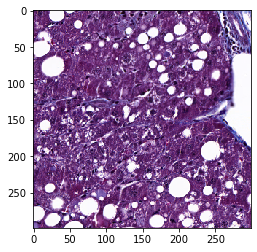

In [5]:
imagesF2 = transform_img_fn([imFilePathF2])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(imagesF2[0] / 2 + 0.5)
preds = loaded_model.predict(imagesF2)
preds

In [6]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 21,815,090
Trainable params: 21,780,652
Non-trainable params: 34,438
___________________________________________________________

In [7]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image


In [8]:
explainer = lime_image.LimeImageExplainer()

In [9]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanationF2 = explainer.explain_instance(imagesF2[0], loaded_model.predict, 
                                         top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 13.9 s, sys: 1.87 s, total: 15.8 s
Wall time: 15 s


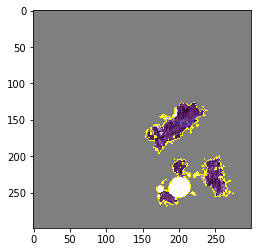

In [10]:
from skimage.segmentation import mark_boundaries


temp, mask = explanationF2.get_image_and_mask(explanationF2.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=True)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))



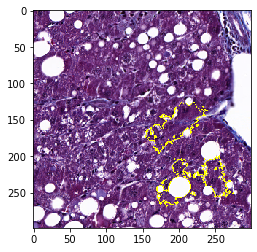

In [12]:
temp, mask = explanationF2.get_image_and_mask(explanationF2.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

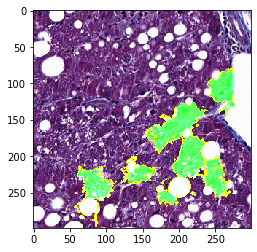

In [13]:
temp, mask = explanationF2.get_image_and_mask(explanationF2.top_labels[0], 
                                            positive_only=False, 
                                            num_features=10, 
                                            hide_rest=False)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

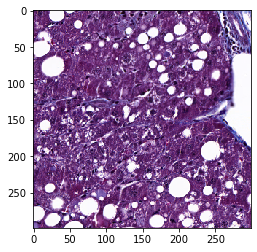

In [14]:
temp, mask = explanationF2.get_image_and_mask(explanationF2.top_labels[0], 
                                            positive_only=False, num_features=1000, 
                                            hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

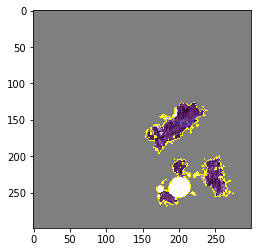

In [15]:
temp, mask = explanationF2.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

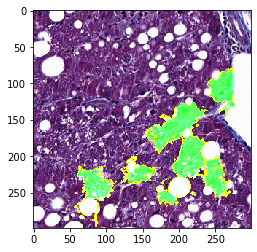

In [16]:
temp, mask = explanationF2.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))